In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import cv2
from tqdm import tqdm
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
dir = "/home/foc-dba-38-0026-c/skin_detction/preprocessed_dataset"

In [3]:
# List subdirectories and sort them in the desired order
subdirectories = [subdir for subdir in os.listdir(dir) if os.path.isdir(os.path.join(dir, subdir))]
desired_order = ['Dry', 'Normal', 'Oily']
subdirectories = sorted(subdirectories, key=lambda x: desired_order.index(x))

# Count the number of image files in each subdirectory
for subdir in subdirectories:
    sub_dir_path = os.path.join(dir, subdir)
    image_files = [file for file in os.listdir(sub_dir_path) if file.lower().endswith(('.jpg','png','jpeg'))]
    num_images = len(image_files)

    print(f"Subdirectory: {subdir}, Number of images: {num_images}")

Subdirectory: Dry, Number of images: 163
Subdirectory: Normal, Number of images: 120
Subdirectory: Oily, Number of images: 273


In [4]:
# Create a dictionary to store unique pixel heights and widths for each class
class_pixel_info = {class_name: {'heights': set(), 'widths': set()} for class_name in desired_order}

# Iterate through the classes in the desired order
for class_name in desired_order:
    class_dir = os.path.join(dir, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg','png','jpeg'))]

    # Calculate unique pixel heights and widths for each image in the class
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            class_pixel_info[class_name]['heights'].add(height)
            class_pixel_info[class_name]['widths'].add(width)

# Print unique pixel heights and widths for each class
for class_name, pixel_info in class_pixel_info.items():
    print(f"Class: {class_name}")
    print("Unique Pixel Heights:", pixel_info['heights'])
    print("Unique Pixel Widths:", pixel_info['widths'])
    print()


Class: Dry
Unique Pixel Heights: {521, 526, 527, 529, 530, 534, 536, 537, 538, 540, 541, 542, 543, 544, 546, 547, 552, 553, 558, 559, 561, 564, 567, 569, 573, 575, 576, 578, 579, 581, 582, 583, 584, 585, 589, 592, 596, 598, 599, 603, 605, 606, 607, 609, 615, 620, 621, 624, 627, 628, 634, 646, 647, 648, 649, 658, 661, 664, 666, 667, 669, 670, 671, 672, 673, 680, 684, 689, 691, 700, 702, 706, 196, 723, 728, 729, 731, 221, 737, 740, 743, 752, 761, 762, 766, 768, 776, 781, 783, 784, 788, 797, 801, 807, 300, 836, 837, 845, 846, 847, 851, 863, 870, 880, 889, 893, 393, 956, 958, 967, 970, 972, 974, 463, 466, 467, 472, 474, 475, 478, 480, 482, 483, 485, 999, 489, 490, 500, 504, 506, 510}
Unique Pixel Widths: {512, 518, 525, 526, 527, 532, 535, 536, 547, 557, 561, 570, 576, 583, 584, 587, 590, 597, 601, 602, 603, 608, 609, 611, 614, 615, 619, 624, 625, 634, 638, 639, 640, 641, 647, 652, 660, 667, 673, 711, 714, 715, 723, 727, 743, 749, 760, 258, 1296, 300, 330, 343, 350, 353, 354, 357, 358, 359

In [5]:
# Output Path for data
output_path = "/home/foc-dba-38-0026-c/skin_detction/version_6_dataset"

In [7]:
# Create training and validating classes
classes = ['Dry', 'Normal', 'Oily']
validation_percentage = 0.1

# Define the directories for training and validation sets
train_dir = os.path.join(output_path, "train")
validation_dir = os.path.join(output_path, "valid")

# Create validation directories if they don't exist
for class_name in classes:
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Move 10% of images from training set to validation set
for class_name in classes:
    images = os.listdir(os.path.join(train_dir, class_name))
    num_validation_images = int(len(images) * validation_percentage)
    validation_images = random.sample(images, num_validation_images)
    
    for image_name in validation_images:
        src_path = os.path.join(train_dir, class_name, image_name)
        dst_path = os.path.join(validation_dir, class_name, image_name)
        shutil.move(src_path, dst_path)

print("Images moved from training set to validation set.")


Images moved from training set to validation set.


In [8]:
train_dir = os.path.join(output_path, 'train')
validation_dir = os.path.join(output_path, 'valid')

# Directory with training images
# train_combination_dir = os.path.join(train_dir, 'Combination')
train_dry_dir = os.path.join(train_dir, 'Dry')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_oily_dir = os.path.join(train_dir, 'Oily')


# Directory with validation cat/dog pictures
# validation_combination_dir = os.path.join(validation_dir, 'Combination')
validation_dry_dir = os.path.join(validation_dir, 'Dry')
validation_normal_dir = os.path.join(validation_dir, 'Normal')
validation_oily_dir = os.path.join(validation_dir, 'Oily')

In [9]:
def count_images_in_folder(folder_path):
    return sum(1 for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png','jpeg')))

# Define your directory paths
directories = {
    'Train dry skin Images': train_dry_dir,
    'Train normal skin Images': train_normal_dir,
    'Train oily skin Images': train_oily_dir,
    '\nValidation dry skin Images': validation_dry_dir,
    'Validation normal skin Images': validation_normal_dir,
    'Validation oily skin Images': validation_oily_dir
}

# Count and print the image counts for each directory
for directory_name, directory_path in directories.items():
    image_count = count_images_in_folder(directory_path)
    print(f"{directory_name}: {image_count}")

Train dry skin Images: 147
Train normal skin Images: 108
Train oily skin Images: 246

Validation dry skin Images: 16
Validation normal skin Images: 12
Validation oily skin Images: 27


In [10]:
# Collect all unique labels from the training and validation data
classes = []
for dirpath in [train_dir, validation_dir]:
    for dirname in os.listdir(dirpath):
        if not dirname.startswith('.'):
            classes.append(dirname)
classes = np.unique(classes)

In [11]:
print(classes)

['Dry' 'Normal' 'Oily']


In [12]:
# Define the input shape and number of classes
input_shape = (248, 248, 3)
num_classes = 3

In [28]:
import tensorflow as tf

class ChannelAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.shared_layer_one = tf.keras.layers.Dense(channels // self.ratio, activation='relu', use_bias=True)
        self.shared_layer_two = tf.keras.layers.Dense(channels, use_bias=True)
        super(ChannelAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Squeeze spatial dimensions
        squeeze = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        
        # Shared MLP
        excitation = self.shared_layer_one(squeeze)
        excitation = self.shared_layer_two(excitation)

        # Channel attention weights
        attention = tf.nn.sigmoid(excitation)
        
        # Scale input by attention weights
        outputs = inputs * attention
        return outputs
    
    def get_config(self):
        config = super(ChannelAttentionLayer, self).get_config()
        config.update({
            'ratio': self.ratio,
        })
        return config

# Define a spatial attention layer with mask
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        # Compute attention weights
        attention_weights = tf.nn.softmax(inputs, axis=1)
        # Apply attention weights to inputs
        if mask is not None:
            attention_weights *= mask
            # Normalize attention weights
            attention_weights /= tf.reduce_sum(attention_weights, axis=1, keepdims=True)
        # Apply attention weights to inputs
        weighted_inputs = inputs * attention_weights
        # Sum along the feature map dimension to compute the attended features
        attended_features = tf.reduce_sum(weighted_inputs, axis=1)
        return attended_features

# Define your CNN architecture with attention and mask
model = tf.keras.models.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(248, 248, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # Hybrid Attention
    ChannelAttentionLayer(), # Apply channel attention first
    AttentionLayer(),  
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 246, 246, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 128)       73856     
_________________________________________________________________
channel_attention_layer_1 (C (None, 58, 58, 128)       4240      
_________________________________________________________________
attention_layer_1 (Attention (None, 58, 128)          

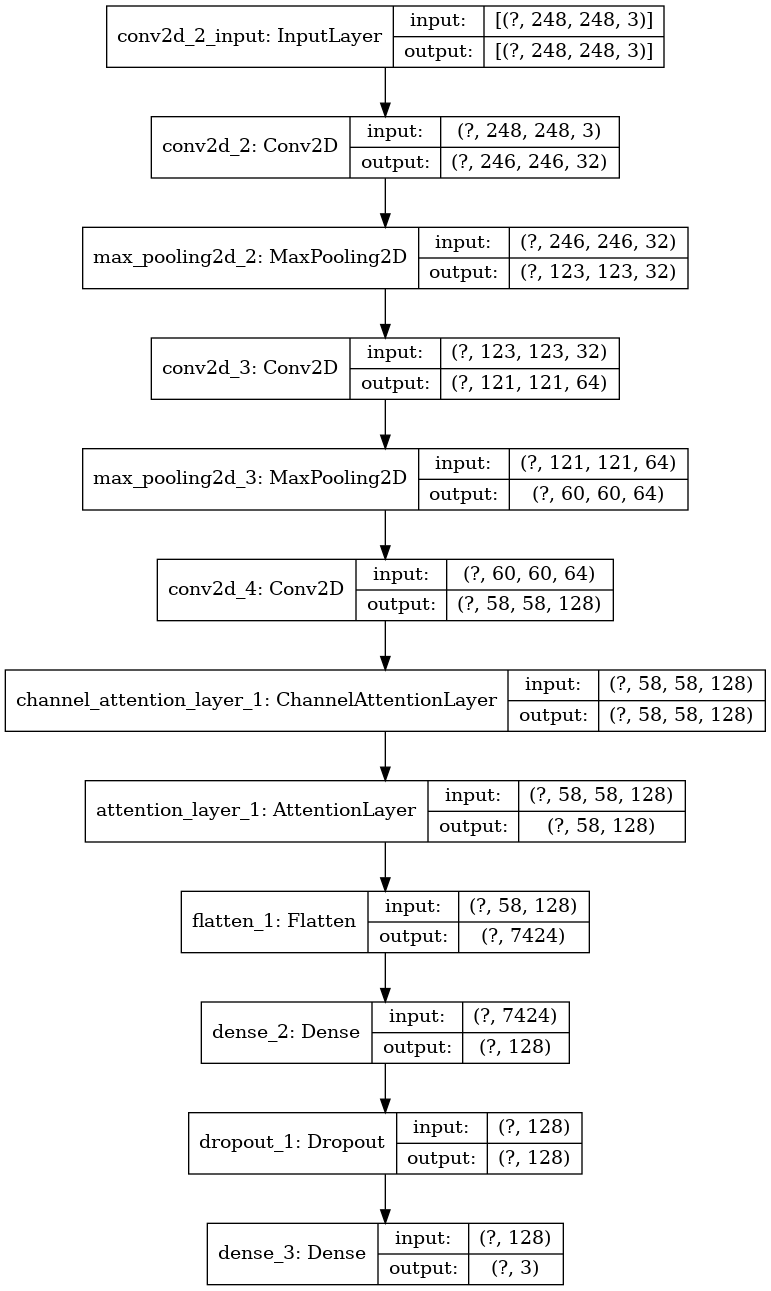

In [30]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(248, 248))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=2,
                                                         class_mode='categorical',
                                                         color_mode='rgb',
                                                         target_size=(248, 248))

Found 501 images belonging to 3 classes.
Found 55 images belonging to 3 classes.


In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [33]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2)

Epoch 1/15
32/32 - 11s - loss: 1.0605 - accuracy: 0.4870 - val_loss: 0.9149 - val_accuracy: 0.4909
Epoch 2/15
32/32 - 11s - loss: 0.8747 - accuracy: 0.6188 - val_loss: 0.8716 - val_accuracy: 0.5818
Epoch 3/15
32/32 - 11s - loss: 0.7696 - accuracy: 0.6906 - val_loss: 0.7008 - val_accuracy: 0.7455
Epoch 4/15
32/32 - 11s - loss: 0.7198 - accuracy: 0.6906 - val_loss: 0.7172 - val_accuracy: 0.7273
Epoch 5/15
32/32 - 11s - loss: 0.6432 - accuracy: 0.7445 - val_loss: 0.6256 - val_accuracy: 0.7273
Epoch 6/15
32/32 - 11s - loss: 0.5717 - accuracy: 0.7565 - val_loss: 0.4991 - val_accuracy: 0.8000
Epoch 7/15
32/32 - 11s - loss: 0.5708 - accuracy: 0.7645 - val_loss: 0.6945 - val_accuracy: 0.6909
Epoch 8/15
32/32 - 11s - loss: 0.5940 - accuracy: 0.7625 - val_loss: 0.4920 - val_accuracy: 0.8182
Epoch 9/15
32/32 - 11s - loss: 0.4391 - accuracy: 0.8084 - val_loss: 0.4563 - val_accuracy: 0.8545
Epoch 10/15
32/32 - 11s - loss: 0.4035 - accuracy: 0.8184 - val_loss: 0.4154 - val_accuracy: 0.9091
Epoch 11/

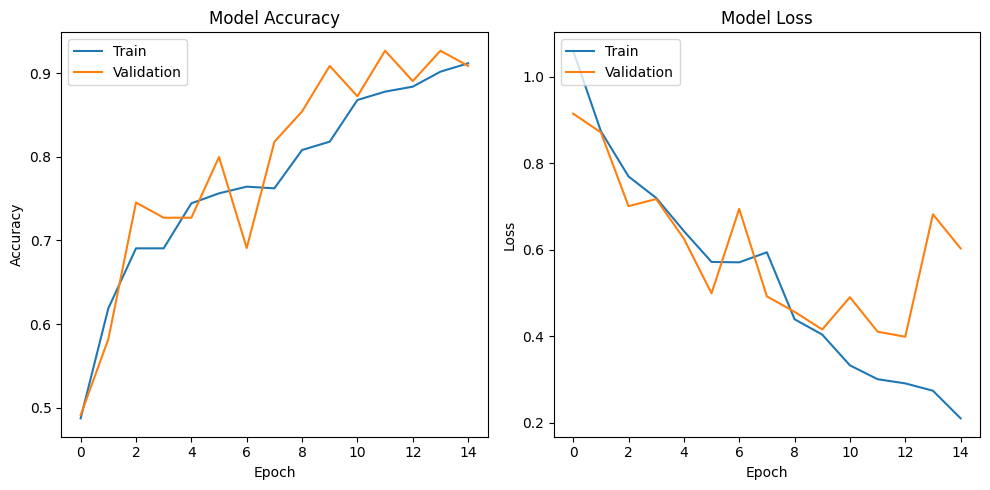

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [35]:
model.save("/home/foc-dba-38-0026-c/skin_detction/version_7/custom_model_version_7.h5")

In [36]:
from sklearn.metrics import confusion_matrix, f1_score

In [50]:
# test_dir = "/home/foc-dba-38-0026-c/skin_detction/synthezised_dataset/train"
# test_dir = "/home/foc-dba-38-0026-c/skin_detction/version_6_dataset/valid"
test_dir = "/home/foc-dba-38-0026-c/skin_detction/synthezised_dataset/valid"
batch_size =2

In [51]:
# Assuming you have your test data in a generator called 'test_generator'
test_data_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(248, 248),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Important to turn off shuffling for proper mapping

filenames = test_data_generator.filenames
nb_samples = len(filenames)
predictions = model.predict_generator(test_data_generator, steps=nb_samples // batch_size+1)
y_pred = np.argmax(predictions, axis=1)  # Get predicted class labels
y_true = test_data_generator.classes  # Get true class labels

Found 55 images belonging to 3 classes.


In [52]:
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[15  1  0]
 [ 3  4  5]
 [ 6  2 19]]


In [53]:
# Macro F1 score (average across classes)
macro_f1 = f1_score(y_true, y_pred, average='macro')
print('Macro F1 Score:', macro_f1)

# Weighted F1 score (considers class imbalance)
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print('Weighted F1 Score:', weighted_f1)

# F1 score for each class
class_f1_scores = f1_score(y_true, y_pred, average=None)
print('F1 Scores per Class:', class_f1_scores)

Macro F1 Score: 0.6387168902648779
Weighted F1 Score: 0.675823247959471
F1 Scores per Class: [0.75       0.42105263 0.74509804]
